In [1]:
# Loading all needed packages at the start
import elastix 
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import shutil
from PIL import Image

from FunctionsImageRegistration import *


## Fill in your own paths in the cell below ##

In [2]:
# to Elastix.exe
ELASTIX_PATH = r'C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe'
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)
# to Transformix.exe
TRANSFORMIX_PATH = r'C:\Users\20191679\Documents\Master\CS_image_analysis\Transformix.exe'
# to TrainingData
filepath_data = r'C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData'

### Default settings


In [3]:
# default settings for MI computation
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'


#### TO DO: Test out hypothesis: does the nr of bins in the MI computation function ever influence the order of the highest MI values?

## Per manually selected fixed image, find the five most similar moving image slices and perform B-spline transformation on them:


In [4]:
# Test set containing p119, p128, and p135 are left out!

patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 'p120', 'p125', 'p127', 'p129', 'p133']
#                    0      1       2       3       4       5       6       7       8       9       10      11       

# load all 12 patients' data (every 3D array) in one list, which has the same order as 'patient_nrs_list'
loaded_mr_list = []
for value in patient_nrs_list:
    loaded_mr, __ = loadPatientDataReadable(value, filepath=filepath_data)
    loaded_mr_list.append(loaded_mr)
    


In [ ]:
# Generate 2D arrays for all patients
for patient_id in range(len(patient_nrs_list)):
    patient_id_fixed_image= patient_nrs_list[patient_id]
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image
    fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_id_fixed_image) # path to fixed image
    create2DImages(fixed_image_path, patient_id_fixed_image, filepath_data)
    create2DMasks(fixed_mask_path,patient_id_fixed_image, filepath_data)

print('Done creating 2D arrays')

In [ ]:
# # Select (for now manually) which image is currently your fixed image -- # Enter image level of one fixed image
# fixed_image_index = 5 # index in patient_nrs_list
# patient_id_fixed_image = patient_nrs_list[fixed_image_index] # patient ID (for example 'p102') of fixed image
    
    
    
for fixed_image_index in range(2):
    patient_id_fixed_image = patient_nrs_list[fixed_image_index] # patient ID (for example 'p102') of fixed image
    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_id_fixed_image) # path to fixed image

    print('Patient selected as fixed image:', patient_id_fixed_image)

    # select all but fixed image to use as moving image
    train_mr_list_moving = []
    for j in loaded_mr_list:
        train_mr_list_moving.append(j)

    fixed_image_mr = train_mr_list_moving.pop(fixed_image_index) # 3D array of fixed image

    # # # # Enter slice iterator of fixed image # # # # 

    for image_slice_fixed in range(86): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 

        print('Fixed image slice nr:', image_slice_fixed)

        list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)

        per_patient_per_slice_MI = intoOneList(list_of_list_MI)

        most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images
        #print(most_similar_list_index)

        patient_ids_similar = []
        slice_ids_similar = []
        for j in most_similar_list_index:
            patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list)
            patient_ids_similar.append(patient_nrs_list[patient_index_a])
            slice_ids_similar.append(actual_slice_nr_a)

        #Initialize segmentations list
        seg_data=[]

        # Perform B-spline registration for each most similar slice and store the results
        # # # # Enter iterator for most similar slices (paired with correct patient) # # # #
        for work_down_list in range(len(patient_ids_similar)): # 0 to 5
            bspline_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data, el_path=el)

            ## Visualization of results, can test below independently
            #visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)
            #visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)

            # Create a new parameter file
            newTransformParameterFile(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data)

            # Bspline registration of masks
            bspline_mask_registration(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 slice_ids_similar[work_down_list], filepath_data, TRANSFORMIX_PATH)

            ##Visualization of masks, can test down below independently
            #visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)

            ## Overlay masks, can test down below independently
            #overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                                 #slice_ids_similar[work_down_list], filepath_data)


            #Save segmentation, maybe we could put this in a function as well but this works too
            output_path_mask = os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(
                    patient_id_fixed_image,image_slice_fixed, patient_ids_similar[work_down_list],slice_ids_similar[work_down_list]))
            file_p_mask=os.path.join(output_path_mask, 'result.mhd')
            readable_mask=imageio.imread(file_p_mask)
            seg_data.append(readable_mask)

        # STAPLE
        combined_seg = Atlas(seg_data)
        plt.imshow(combined_seg)

        # Save the result
        image_path=os.path.join(filepath_data, patient_id_fixed_image)
        img_name= 'result_{}_slice{}.png'.format(patient_id_fixed_image, image_slice_fixed)
        img = Image.fromarray(combined_seg*255)
        #plt.imshow(combined_seg)
        img = img.convert("L")
        img.save(os.path.join(image_path,img_name))

    #     #Evaluation
    #     fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed) # path to fixed image
    #     result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id_fixed_image,image_slice_fixed))

    #     dice_coeff= diceFunction(result_path, fixed_mask_path)
    #     quality= computeQualityMeasures(result_path, fixed_mask_path)
    #     print(dice_coeff, quality)

Patient selected as fixed image: p102
Fixed image slice nr: 0
C:\Users\20191679\Documents\Master\CS_image_analysis\Elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice0.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p115\p115_slice0.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_0\moving_slice_p115_0


In [6]:
## Evaluation separately, could put this in a function but this works as well
dice_coeffs=[]
hausdorff_95=[]

for patient_id in patient_nrs_list:

    for slice_id in range(86):
        fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id, patient_id, slice_id) # path to fixed image
        result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id,slice_id))
    
        dice_coeff= diceFunction(result_path, fixed_mask_path)
        dice_coeffs.append(dice_coeff)
        quality= computeQualityMeasures(result_path, fixed_mask_path)
        hausdorff_95.append(quality.get('hausdorff_95'))
        print(dice_coeff, quality)
        print(dice_coeffs, hausdorff_95)

avg_dice= np.mean(dice_coeffs)
av_hausdorff_95=np.mean(hausdorff_95)

p102
p107
p108
p109
p115
p116
p117
p120
p125
p127
p129
p133


Fixed image slice nr: 30


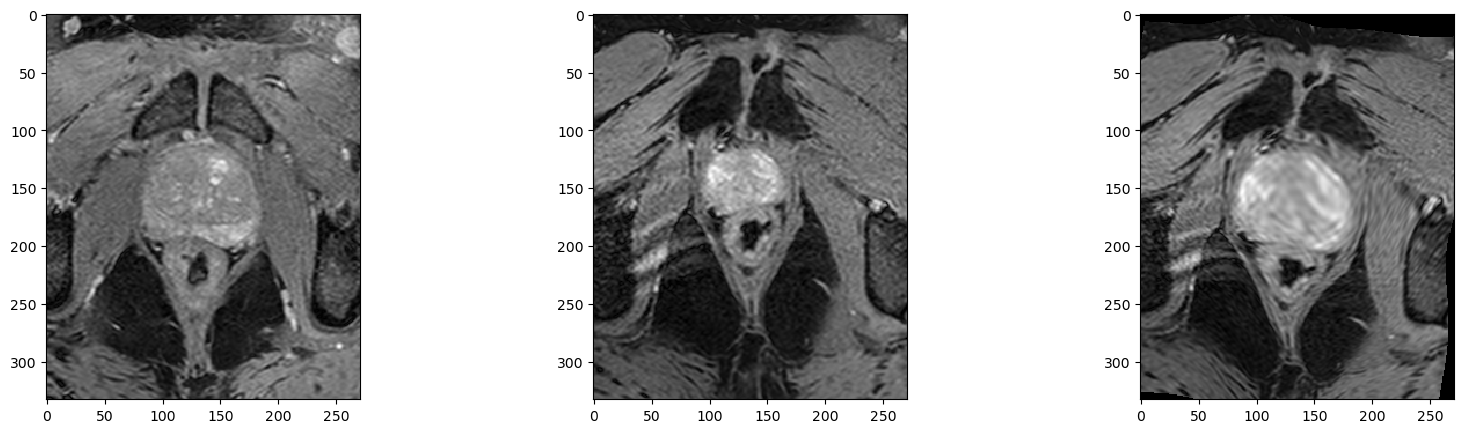

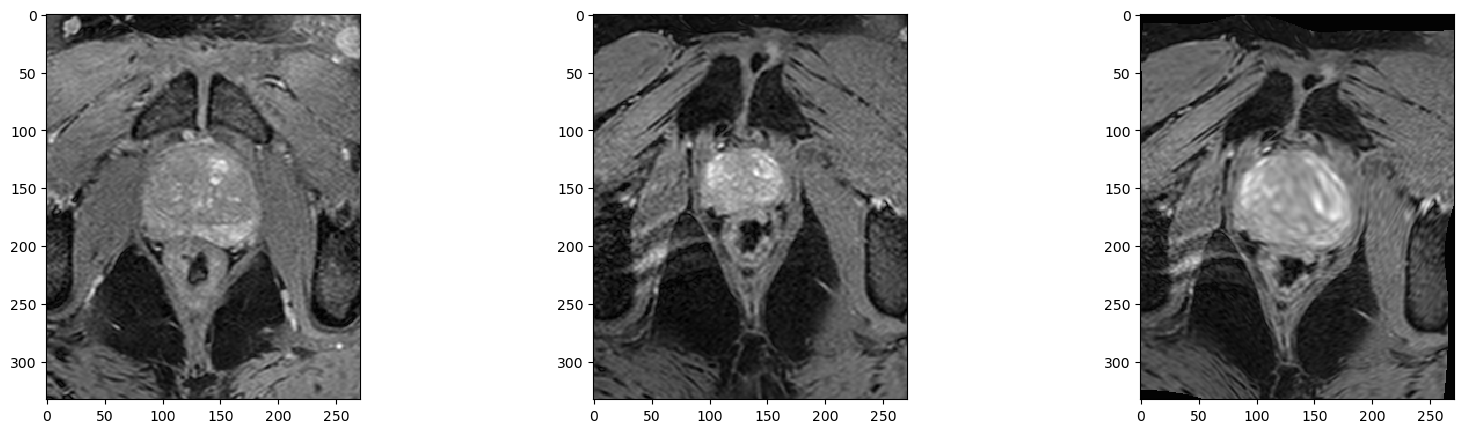

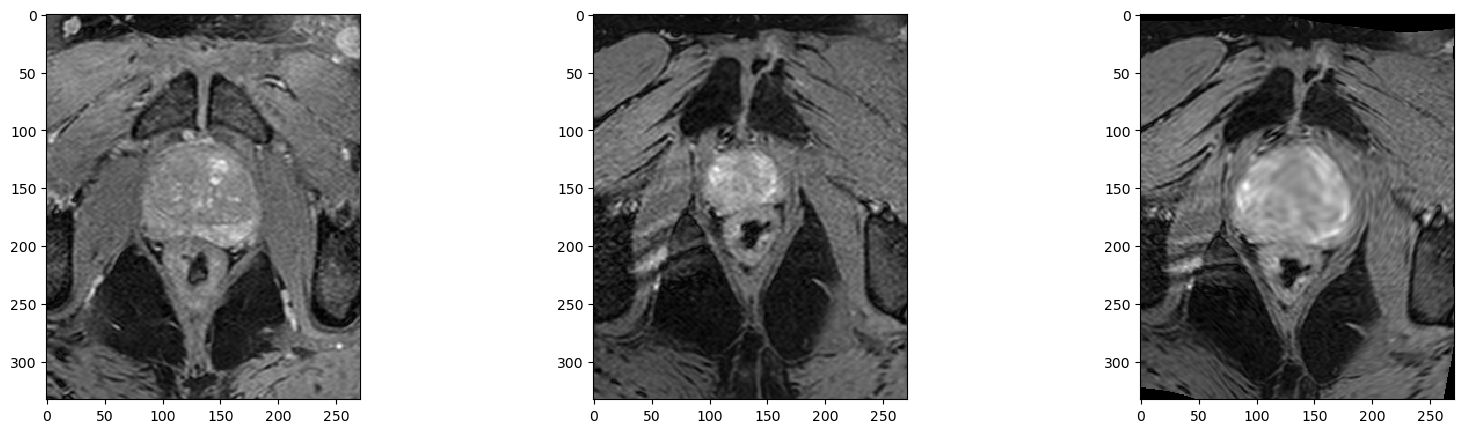

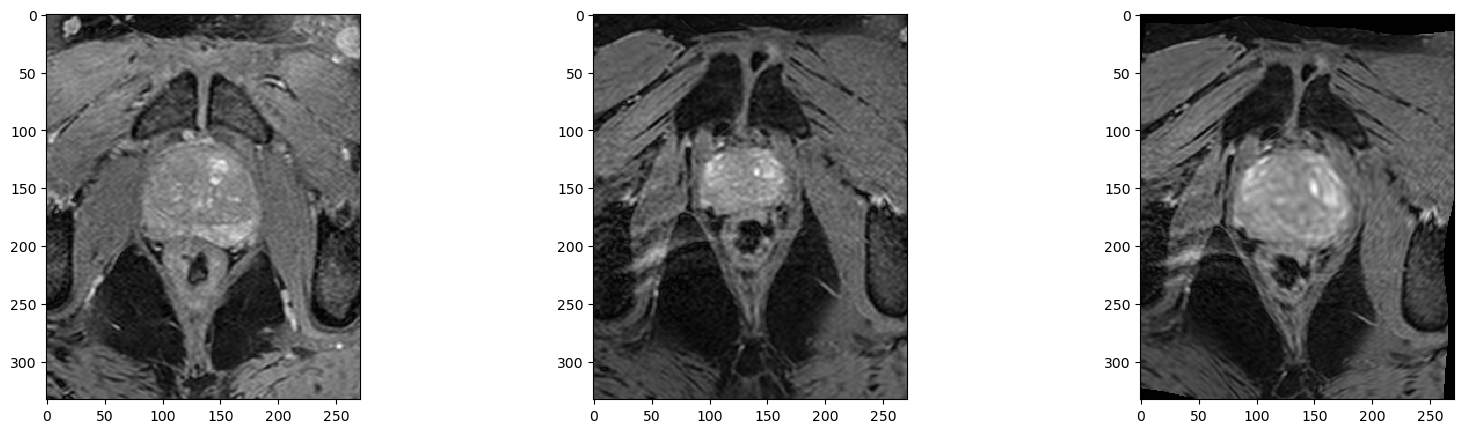

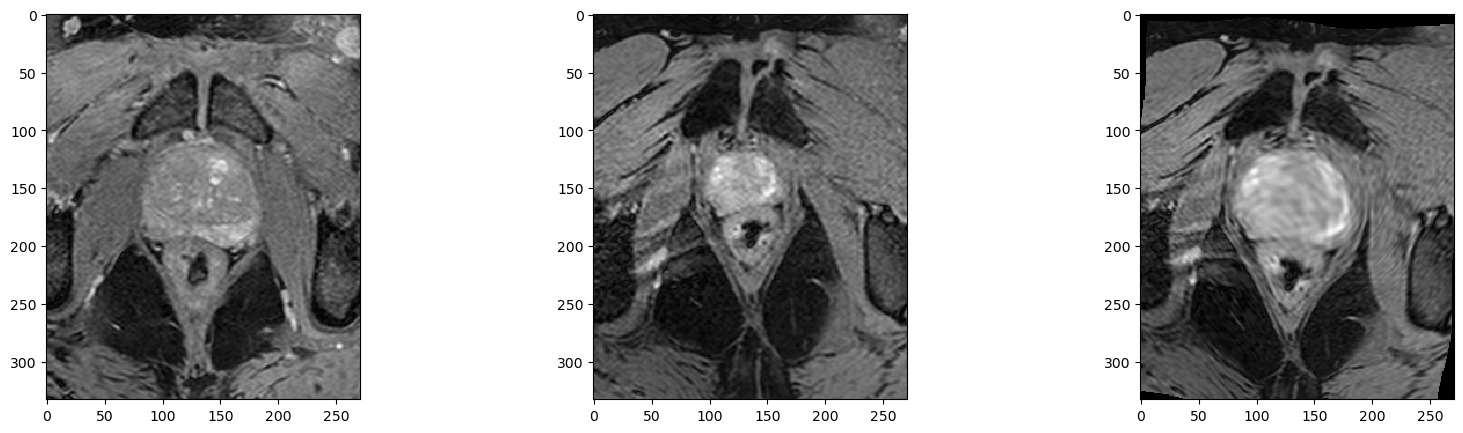

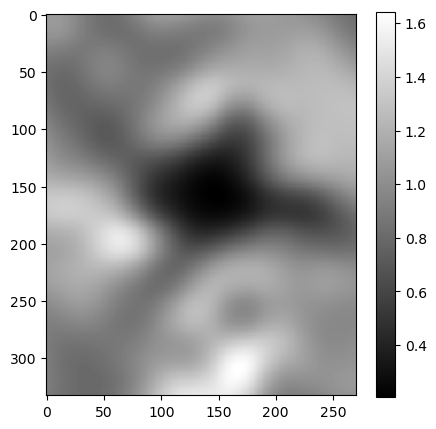

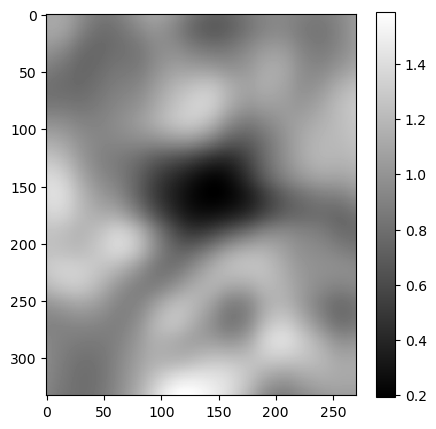

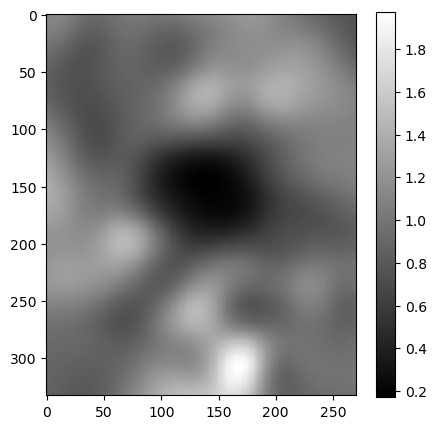

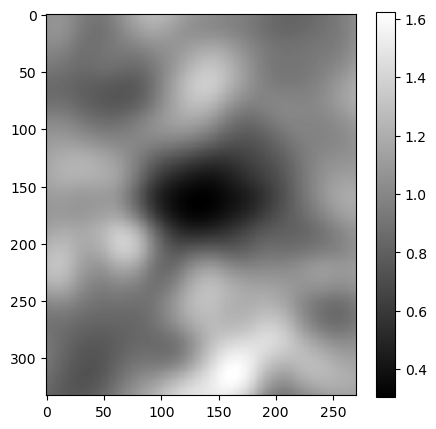

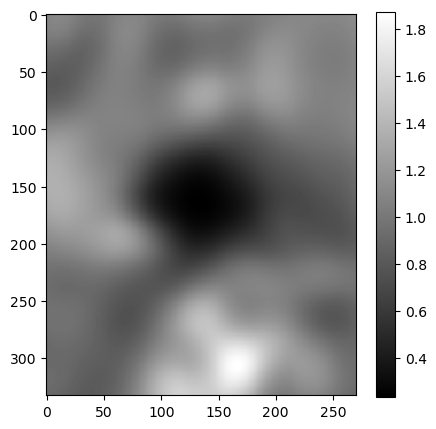

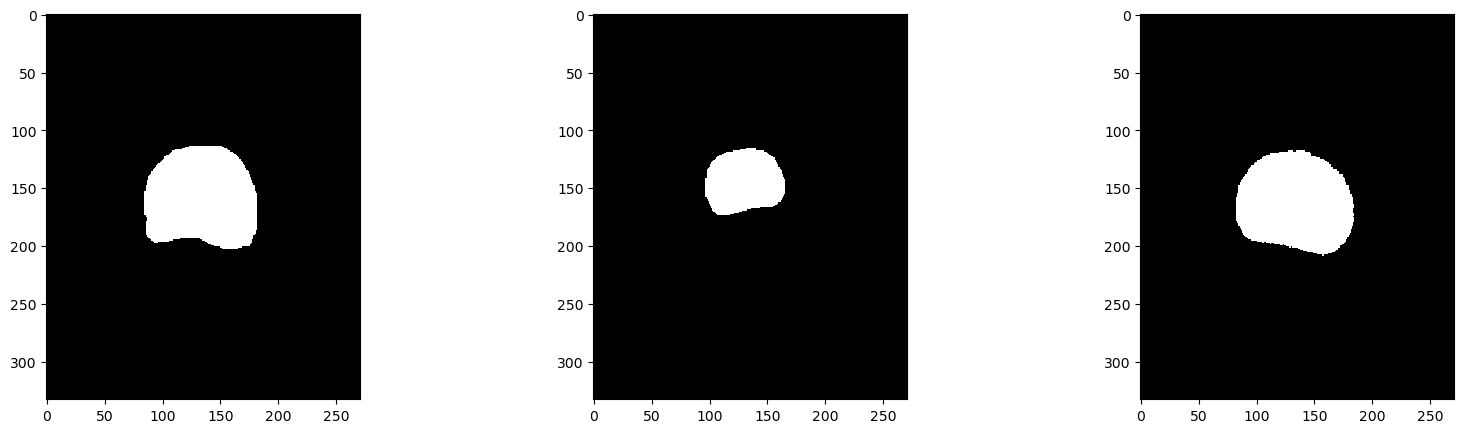

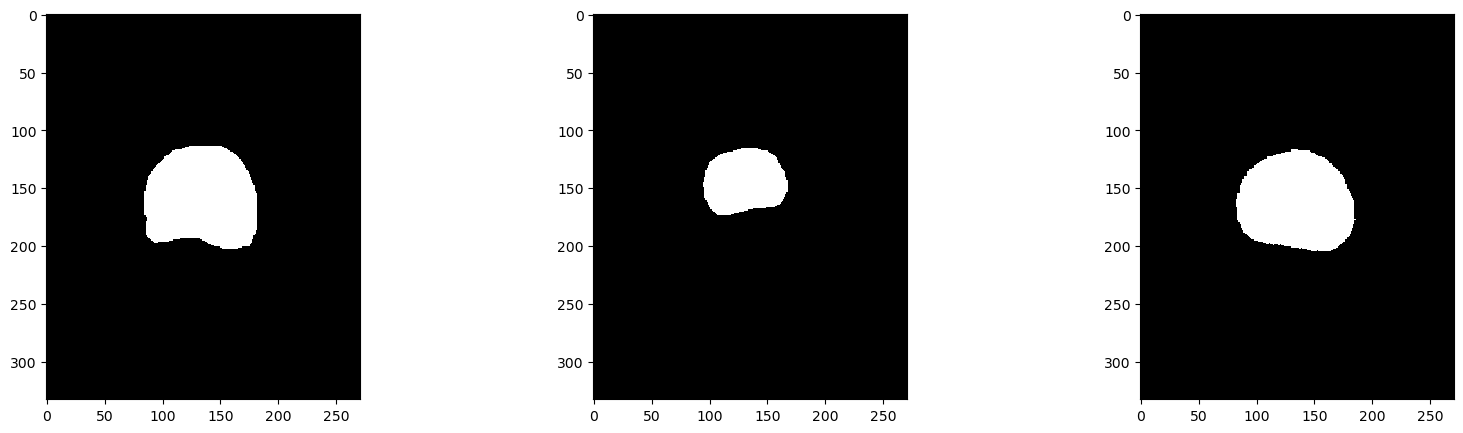

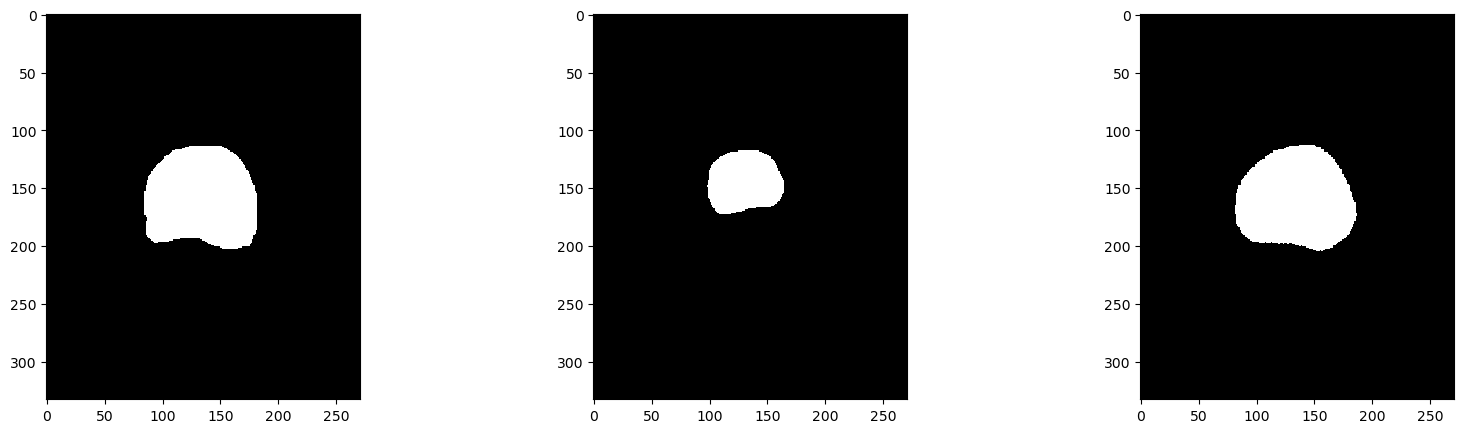

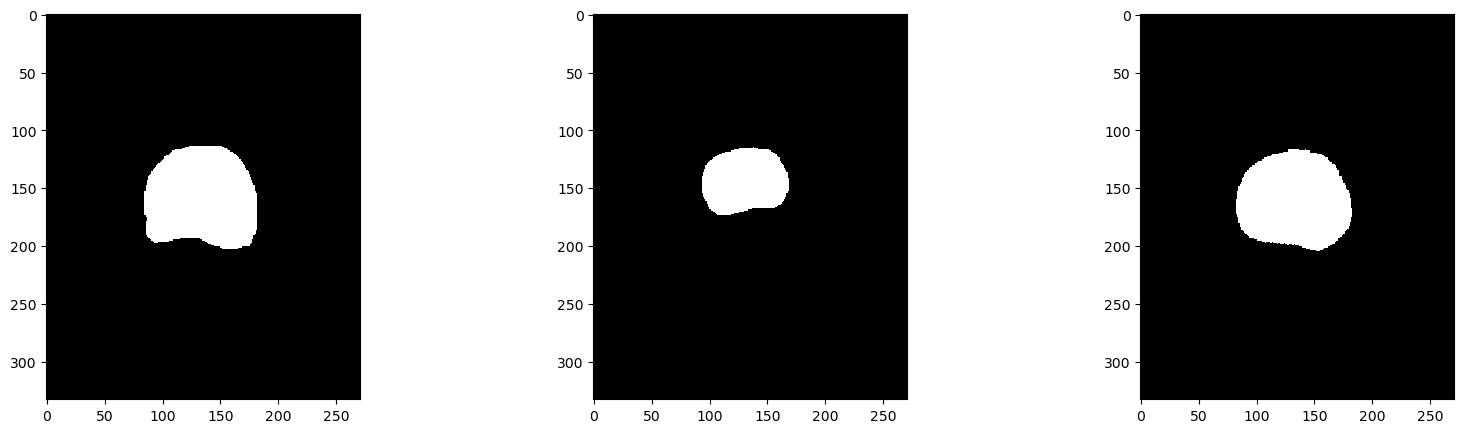

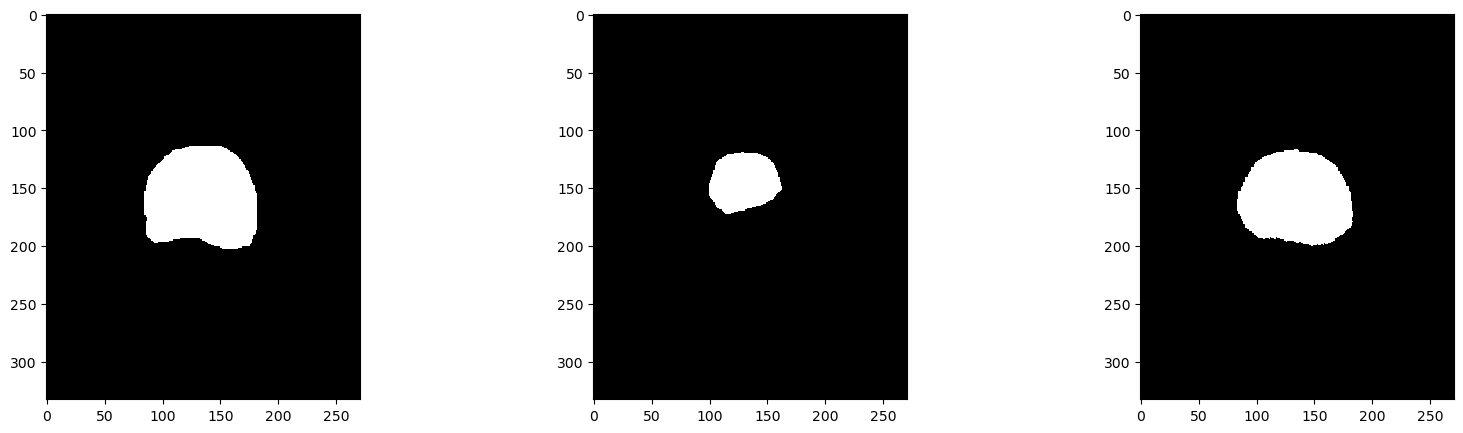

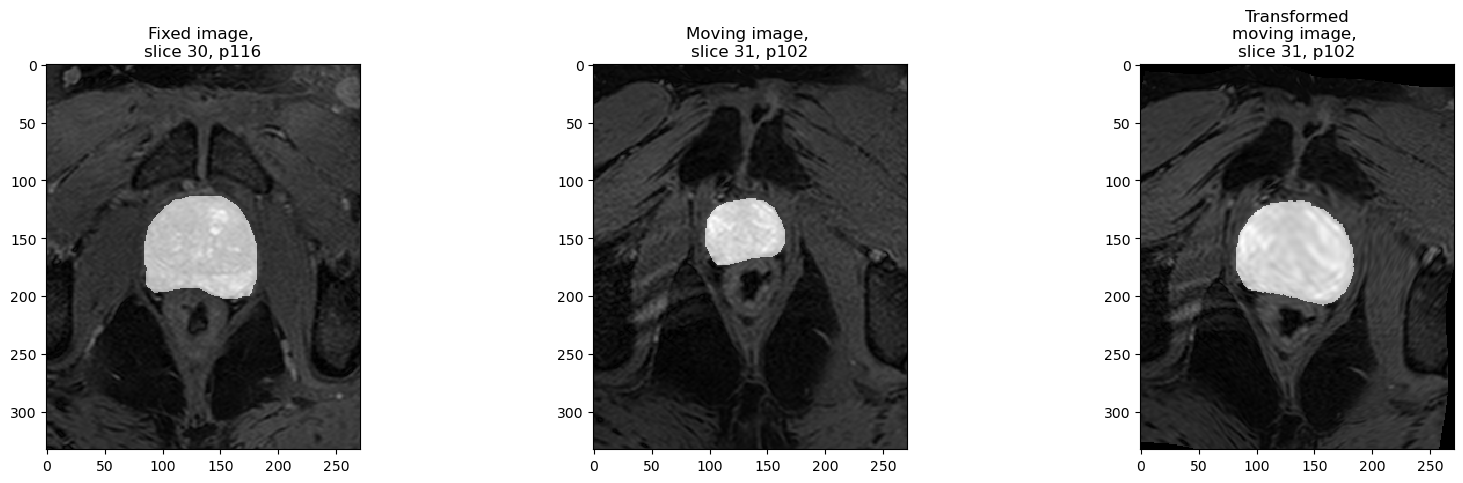

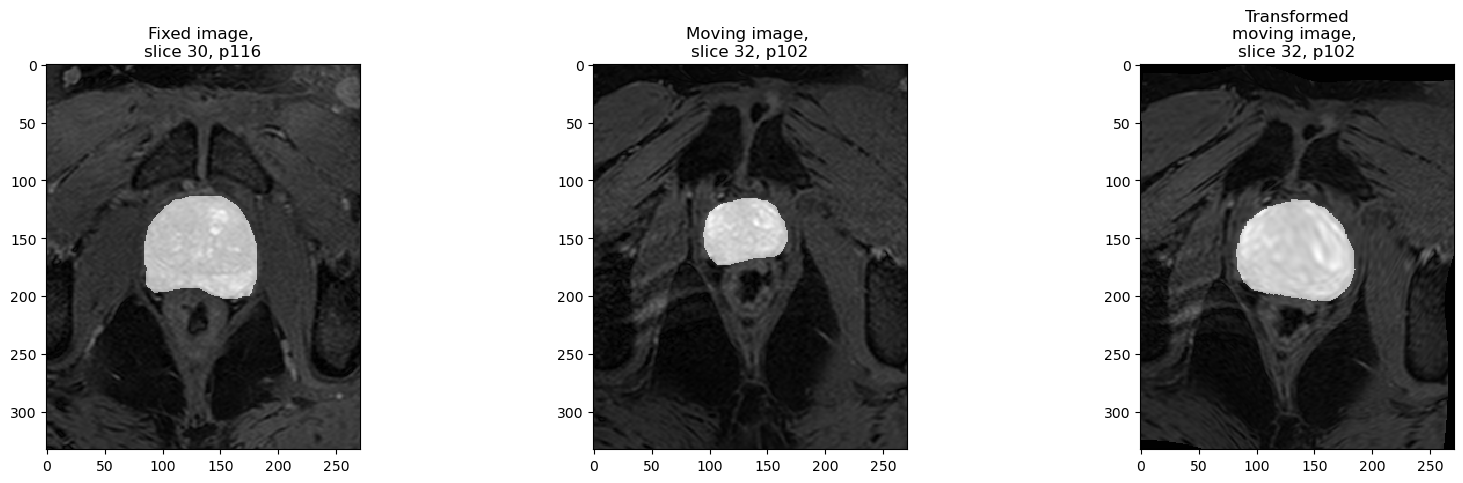

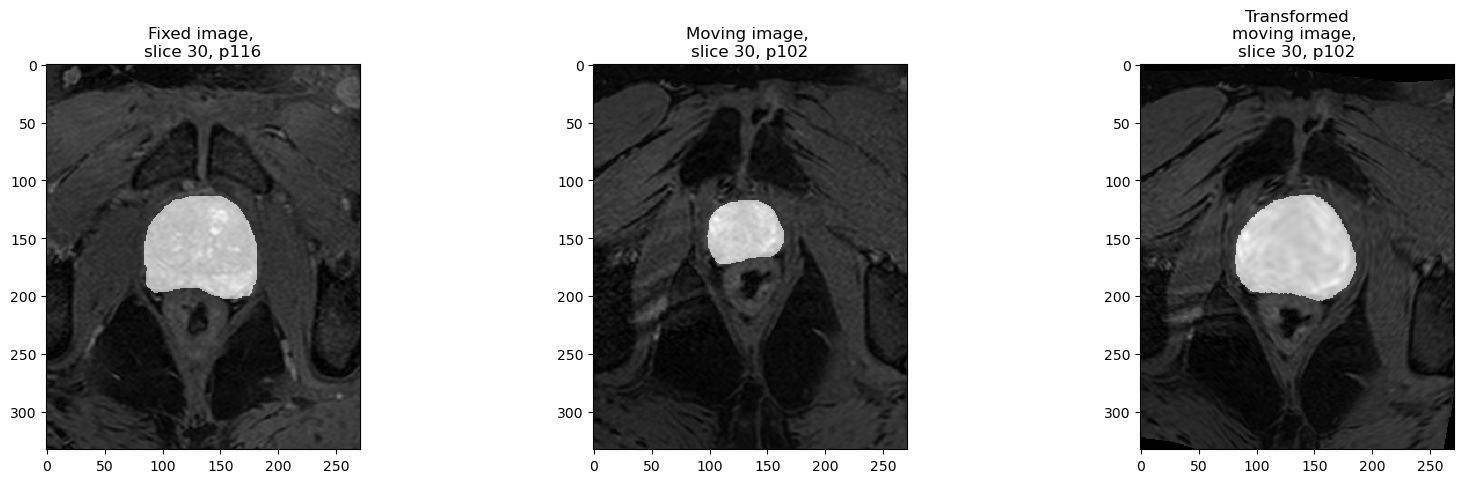

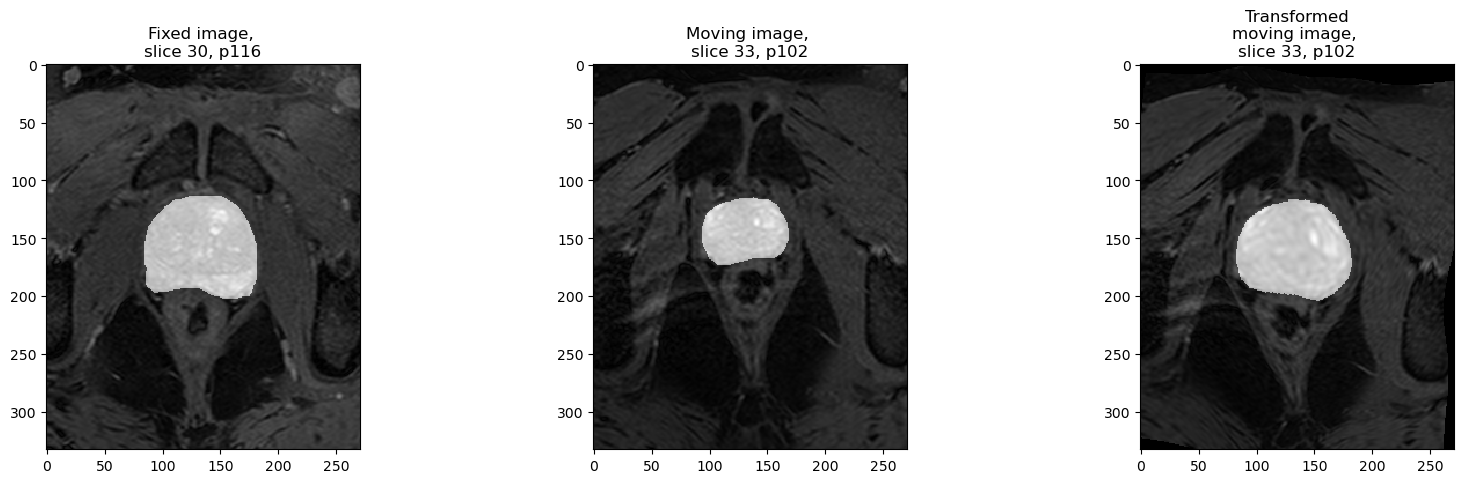

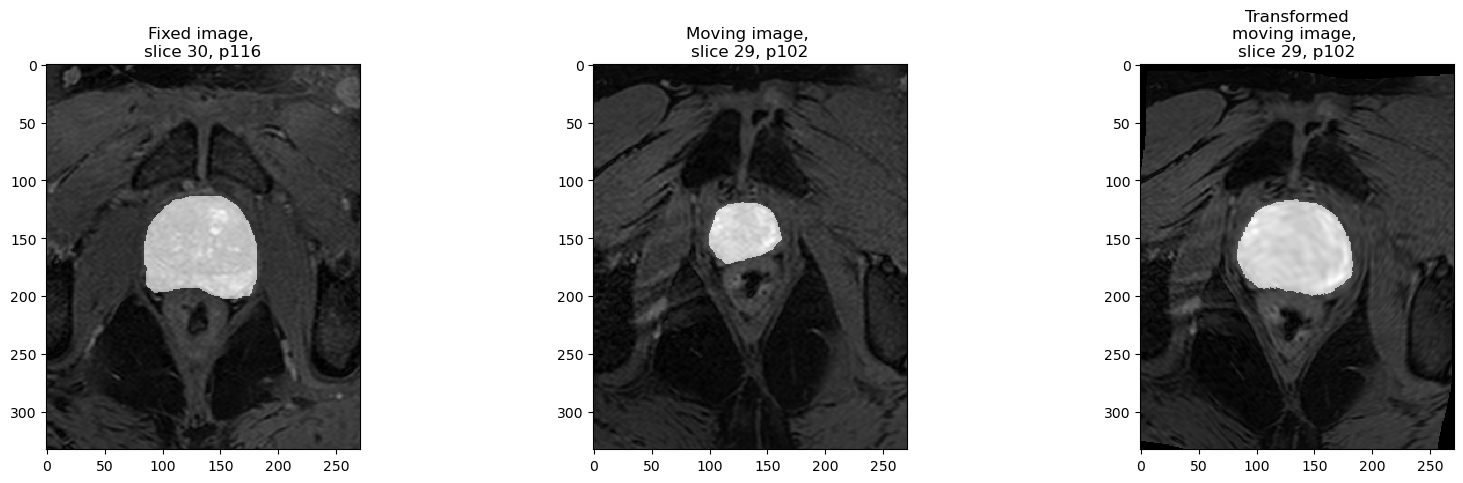

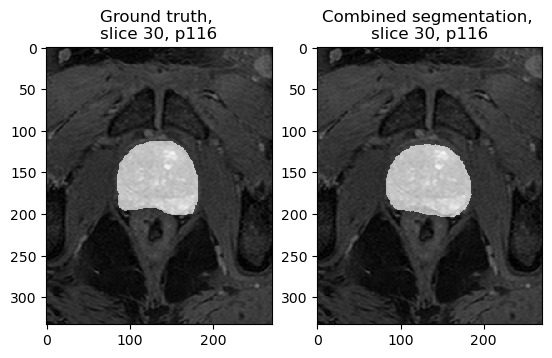

In [19]:
## Visualization of results separately
for image_slice_fixed in range(30,31): # when everything works: use 86. When everything is still being tested: keep it simple with 4. 
    
    #First get most similar slices (again)
    print('Fixed image slice nr:', image_slice_fixed)

    list_of_list_MI, list_moving_slices_used = allMImovingImages(train_mr_list_moving, image_slice_fixed, fixed_image_mr)

    per_patient_per_slice_MI = intoOneList(list_of_list_MI)

    most_similar_list_index = sort_index(per_patient_per_slice_MI)[:5] # Get the five most similar images of all moving images

    patient_ids_similar = []
    slice_ids_similar = []
    for j in most_similar_list_index:
        patient_index_a, actual_slice_nr_a = getPatientAndSlice(j, list_moving_slices_used, train_mr_list_moving, patient_nrs_list)
        patient_ids_similar.append(patient_nrs_list[patient_index_a])
        slice_ids_similar.append(actual_slice_nr_a)
        
    # Visualization of results
    #registration
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5
        visualize_bspline_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    #jacobian
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5
        visualize_jacobian(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data, tr_path=TRANSFORMIX_PATH)
    #mask registration
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
        visualize_bspline_mask_results(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    #mask overlay
    for work_down_list in range(len(patient_ids_similar)): # 0 to 5    
        overlay_mask(patient_id_fixed_image, patient_ids_similar[work_down_list], image_slice_fixed, 
                             slice_ids_similar[work_down_list], filepath_data)
    #combined segmentation, overlays the masks over the original image
    #could also put this into a function    
    fixed_mask_path = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed) 
    result_path=os.path.join(filepath_data,patient_id_fixed_image, 'result_{}_slice{}.png'.format(patient_id_fixed_image,image_slice_fixed))
    fixed_image_path = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_id_fixed_image, patient_id_fixed_image, image_slice_fixed)
    
    readable_fixed = imageio.imread(fixed_image_path)
    
    itk_mask_fixed = sitk.ReadImage(fixed_mask_path)
    mask_array_fixed = sitk.GetArrayFromImage(itk_mask_fixed)
    
    itk_mask_result= sitk.ReadImage(result_path)
    mask_array_result = sitk.GetArrayFromImage(itk_mask_result)
    
    fig,ax=plt.subplots(1,2)
    ax[0].imshow(readable_fixed[:,:], cmap='gray')
    ax[0].imshow(mask_array_fixed[:,:], cmap='gray', alpha=0.5)
    ax[0].set_title('Ground truth, \nslice {}, {}'.format(image_slice_fixed, patient_id_fixed_image))
    ax[1].imshow(readable_fixed[:,:], cmap='gray')
    ax[1].imshow(mask_array_result, cmap='gray', alpha=0.5)
    ax[1].set_title('Combined segmentation, \nslice {}, {}'.format(image_slice_fixed, patient_id_fixed_image))
    